In [1]:
import sys
sys.path.append('..')

In [2]:
import explain_utils
import explainer

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

### Load data

In [4]:
# dataset = 'Cora'
dataset = 'Citeseer'
dataset = Planetoid('data', dataset, transform=T.NormalizeFeatures())
data = dataset[0]

### Build Model

In [5]:
class Model(nn.Module):
    def __init__(self, feature_num: int, hidden_size: int = 8, heads: int = 8, dropout: float = 0.5):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(feature_num, hidden_size, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_size * heads, hidden_size, heads=heads, concat=True, dropout=dropout)

    def forward(self, x, edge_index):
        attentions = []

        x = nn.Dropout(p=self.dropout)(x)
        x, (attn_edge_index, attn_weight) = self.conv1(x, edge_index, return_attention_weights=True)
        attentions.append((attn_edge_index.detach(), attn_weight.detach()))
        x = nn.ELU()(x)

        x = nn.Dropout(p=self.dropout)(x)
        x, (attn_edge_index, attn_weight) = self.conv2(x, edge_index, return_attention_weights=True)
        attentions.append((attn_edge_index.detach(), attn_weight.detach()))

        return nn.LogSoftmax(dim=1)(x), attentions

In [6]:
model = Model(dataset.num_node_features, hidden_size=16, heads=4, dropout=0.3)

### Train

In [7]:
@torch.no_grad()
def eval(model, data):
    model.eval()
    (logits, _), accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

def train(model, data, num_epochs, lr=0.005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits, attentions = model(data.x, data.edge_index)
        loss = nn.NLLLoss()(logits[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            train_acc, val_acc, test_acc = eval(model, data)
            print(f'Epoch: {epoch}, train loss: {loss.item():.4f}, train acc: {train_acc:4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

In [8]:
model = Model(dataset.num_node_features, hidden_size=16, heads=4, dropout=0.5)
train(model, data, 400, lr=0.01)

Epoch: 10, train loss: 2.9152, train acc: 0.300000, Val: 0.1840, Test: 0.1690
Epoch: 20, train loss: 1.9885, train acc: 0.458333, Val: 0.2840, Test: 0.2760
Epoch: 30, train loss: 1.8140, train acc: 0.416667, Val: 0.3500, Test: 0.3410
Epoch: 40, train loss: 1.6574, train acc: 0.608333, Val: 0.3260, Test: 0.3410
Epoch: 50, train loss: 1.7052, train acc: 0.608333, Val: 0.4000, Test: 0.3590
Epoch: 60, train loss: 1.5668, train acc: 0.608333, Val: 0.4560, Test: 0.4540
Epoch: 70, train loss: 1.6543, train acc: 0.741667, Val: 0.4640, Test: 0.4510
Epoch: 80, train loss: 1.4092, train acc: 0.783333, Val: 0.5680, Test: 0.5150
Epoch: 90, train loss: 1.3152, train acc: 0.833333, Val: 0.5420, Test: 0.5290
Epoch: 100, train loss: 1.2421, train acc: 0.808333, Val: 0.5820, Test: 0.5790
Epoch: 110, train loss: 1.1962, train acc: 0.875000, Val: 0.5760, Test: 0.5680
Epoch: 120, train loss: 1.1397, train acc: 0.891667, Val: 0.5940, Test: 0.5930
Epoch: 130, train loss: 1.3202, train acc: 0.908333, Val: 0.5

### Get Attentions

In [9]:
model.eval()
with torch.no_grad():
    logits, attentions = model(data.x, data.edge_index)

In [10]:
print('======Layer 1======')
attn1 = attentions[0][1]
print(attn1.min(-1)[0].mean())
print((attn1.max(-1)[0] - attn1.min(-1)[0]).mean())
print(attn1.mean(-1).mean())
print(attn1.mean(-1).std())

print('======Layer 2======')
attn2 = attentions[1][1]
print(attn2.min(-1)[0].mean())
print((attn2.max(-1)[0] - attn2.min(-1)[0]).mean())
print(attn2.mean(-1).mean())
print(attn2.mean(-1).std())

======Layer 1======
tensor(0.2463)
tensor(0.0437)
tensor(0.2676)
tensor(0.1581)
======Layer 2======
tensor(0.2631)
tensor(0.0090)
tensor(0.2676)
tensor(0.1570)


In [11]:
def get_attention_tensors(attentions):
    ret = []
    for edge_indices, attention_weights in attentions:
        edge_indices = edge_indices.numpy().T
        attention_weights = explain_utils.attention_weights_pooling(attention_weights.numpy(), 'mean')
        ret.append((edge_indices, attention_weights))
    return ret

### Top paths cumlative importance

100%|██████████| 3327/3327 [00:00<00:00, 9214.84it/s]


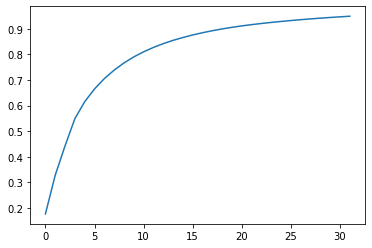

In [12]:
topk = 32
top_path_scores = explain_utils.viterbi(get_attention_tensors(attentions), topk=topk)
cum_imp = []
for i, (node, path_scores) in enumerate(top_path_scores.items()):
    #if i > 100:
    #    break
    #print(sum(top_scores[node]))
    cum = []
    for path, score in path_scores.items():
        if cum:
            cum.append(cum[-1] + score)
        else:
            cum.append(score)
    cum += [1] * (topk - len(cum))
    cum_imp.append(cum)
    #    print(path, score)
    #print()
cum_imp = np.array(cum_imp)
plt.plot(cum_imp.mean(0))

### Top paths (remove duplicated) cumlative importance

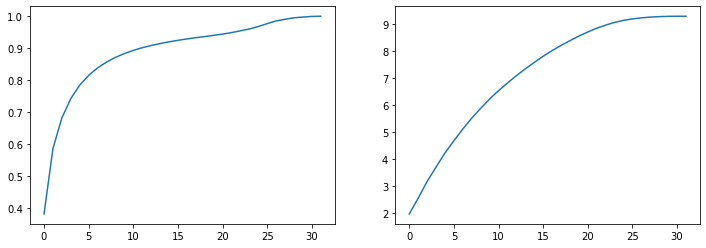

In [13]:
cum_imp = []
cum_node_cnt = []
for i, (node, path_scores) in enumerate(top_path_scores.items()):
    cum = []
    cum2 = []
    cum_nodes = set()
    norm_scores = {}
    for path, score in path_scores.items():
        path = tuple(list(sorted(set(path))))
        norm_scores[path] = norm_scores.get(path, 0) + score
    norm_scores = list(sorted(list(norm_scores.items()), key=lambda _: _[1], reverse=True))
    for path, score in norm_scores:
        if cum:
            cum.append(cum[-1] + score)
        else:
            cum.append(score)
        cum_nodes |= set(path)
        cum2.append(len(cum_nodes))
    cum += [1] * (32 - len(cum))
    cum2 += [cum2[-1]] * (32 - len(cum2))
    cum_imp.append(cum)
    cum_node_cnt.append(cum2)
    #    print(path, score)
    #print()
cum_imp = np.array(cum_imp)
cum_node_cnt = np.array(cum_node_cnt)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(cum_imp.mean(0))
plt.subplot(1,2,2)
plt.plot(cum_node_cnt.mean(0))

### Explainer

In [14]:
ex = explainer.NodeClassificationExplainer()
ex.fit(get_attention_tensors(attentions), topk=16)

100%|██████████| 3327/3327 [00:00<00:00, 10002.52it/s]


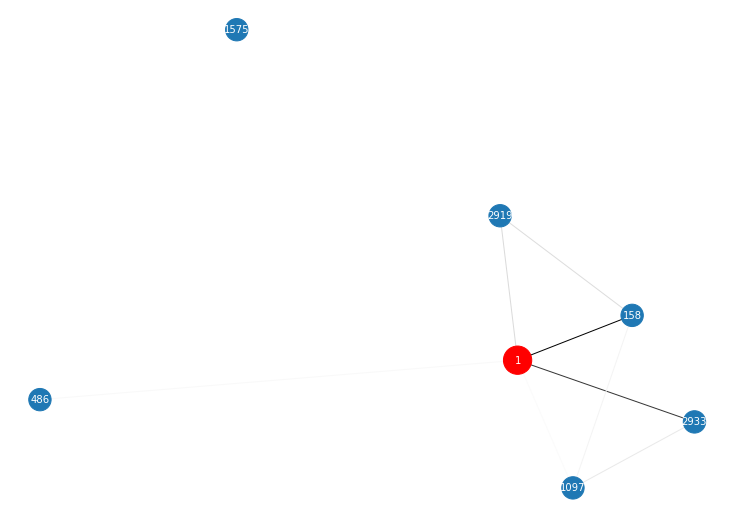

(OrderedDict([((1, 2933, 1), 0.05705332),
              ((2933, 2933, 1), 0.054213725),
              ((1097, 2933, 1), 0.0531037),
              ((158, 158, 1), 0.04789295),
              ((2919, 158, 1), 0.045483362),
              ((1, 158, 1), 0.041688442),
              ((1097, 158, 1), 0.03858503),
              ((158, 1, 1), 0.032531757),
              ((2919, 1, 1), 0.030790038),
              ((486, 1, 1), 0.028803866),
              ((1, 1, 1), 0.028707761),
              ((2933, 1, 1), 0.02667225),
              ((1097, 1, 1), 0.02599844),
              ((158, 2919, 1), 0.020759681),
              ((2919, 2919, 1), 0.019572424),
              ((1575, 2919, 1), 0.018330373)]),
 <networkx.classes.graph.Graph at 0x22795b48e48>)

In [15]:
ex.explain(1)